In [ ]:
# hide
# all_tutorial

# Tutorial - VAE Models

>Training and using VAE models

## Variational Autoencoders

Variational Autoencoders (VAEs) are a type of encoder-decoder model. The task of the model is to take some input, map the input to a latent space using the encoder, then reconsruct the input from the latent vector. We can extend this framework more broadly to "paired data reconsruction" where the inputs are not literally the same as the outputs. For example, reconstructing a SMILES string from a molecular fingerprint.

VAEs impose a constraint on the latent space that it be close to a unit Gaussian. This means we can sample valid latent vectors by sampling from a normal distribution.

During generation, we sample from the model in an autoregression fashion. First we sample a latent vector. Then the model predicts a probability distribution over he next token. We then sample from that distribution and feed the selected token back into the model. We repeat this process until either an end of sentence (EOS) token is predicted, or the generated sequence reaches a maximum allowed length.

During sampling, we save the log probability of each token predicted. This gives us a probability value for the model's estimated likelihood of the generated compound. We can also backprop through this value.

In [ ]:
import sys
sys.path.append('..')

from mrl.imports import *
from mrl.core import *
from mrl.chem import *
from mrl.torch_imports import *
from mrl.torch_core import *
from mrl.layers import *
from mrl.dataloaders import *
from mrl.g_models.all import *
from mrl.train.agent import *
from mrl.vocab import *

/home/dmai/miniconda3/envs/mrl/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.
  return f(*args, **kwds)


## Setup

Before creating a model, we need to set up our data.

Our raw data is in the form of SMILES strings. We need to convert these to tensors.

First we need a `Vocab` to handle converting strings to tokens and mapping those tokens to integers. We will use the `CharacterVocab` class with the `SMILES_CHAR_VOCAB` vocabulary. This will tokenize SMILES on a character basis.

More sophisticated tokenization schemes exist, but character tokenization is nice for the simplicity. Character tokenization has a small, compact vocabulary. Other tokenization strategies can tokenize by more meaningful subwords, but these strategies create a long tail of low frequency tokens and lots of `unk` characters.

In [ ]:
df = pd.read_csv('files/smiles.csv')

In [ ]:
df.head()

,smiles
0,CNc1nc(SCC(=O)Nc2cc(Cl)ccc2OC)nc2ccccc12
1,COc1ccc(C(=O)Oc2ccc(/C=C3\C(=N)N4OC(C)=CC4=NC3...
2,Cc1sc(NC(=O)c2ccccc2)c(C(N)=O)c1C
3,COc1ccc(NCc2noc(-c3ccoc3)n2)cc1OC(F)F
4,O=C(COC(=O)c1cccc(Br)c1)c1ccc2c(c1)OCCCO2


In [ ]:
vocab = CharacterVocab(SMILES_CHAR_VOCAB)

`vocab` first tokenizes smiles into characters, then numericalizes the tokens into integer keys

In [ ]:
' '.join(vocab.tokenize(df.smiles.values[0]))

'bos C N c 1 n c ( S C C ( = O ) N c 2 c c ( C l ) c c c 2 O C ) n c 2 c c c c c 1 2 eos'

In [ ]:
' '.join([str(i) for i in vocab.numericalize(vocab.tokenize(df.smiles.values[0]))])

'0 23 27 34 11 37 34 5 30 23 23 5 20 28 6 27 34 12 34 34 5 23 36 6 34 34 34 12 28 23 6 37 34 12 34 34 34 34 34 11 12 1'

## Dataset

Now we need a dataset. We have to decide what data we want to send to the encoder to generate a latent vector. 

For this tutorial, we are going to use molecular fingerprints to generate the latent vector. The model will use the encoder to map the input fingerprint to a latent vector. Then the latent vector will be used to condition the decoder, which will reconstruct the SMILES string corresponding to the fingerprint.

To do this, we will use the `Vec_To_Text_Dataset` dataset with `ECFP6` as our fingerprint function 

In [ ]:
dataset = Vec_To_Text_Dataset(df.smiles.values, vocab, ECFP6)
dataloader = dataset.dataloader(32)

Now we can look at the actual data

In [ ]:
x,y = next(iter(dataloader))

In [ ]:
x

(tensor([[ 0, 23, 27,  ...,  2,  2,  2],
         [ 0, 23, 28,  ...,  2,  2,  2],
         [ 0, 23, 34,  ...,  2,  2,  2],
         ...,
         [ 0, 23,  4,  ...,  2,  2,  2],
         [ 0, 23, 23,  ...,  2,  2,  2],
         [ 0, 23, 28,  ...,  2,  2,  2]]),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]))

In [ ]:
y

tensor([[23, 27, 34,  ...,  2,  2,  2],
        [23, 28, 34,  ...,  2,  2,  2],
        [23, 34, 11,  ...,  2,  2,  2],
        ...,
        [23,  4, 23,  ...,  2,  2,  2],
        [23, 23, 11,  ...,  2,  2,  2],
        [23, 28, 34,  ...,  2,  2,  2]])

The `x` tensor is a tuple containing `(fingerprint, smiles_ints)`. The fingerprint (`x[1]`) will be used to generate the latent vector, while the integer-coded SMILES string (`x[0]`) will be sent to the decoder along with the latent vector.

You will notice the `y` tensor is the same as the `x[0]` tensor with the values shifted by one. This is because the goal of autoregressive language modeling is to predict the next character given the previous series of characters.

## Model Creation

We can create a model through the `MLP_VAE` class.


In [ ]:
d_vocab = len(vocab.itos)
bos_idx = vocab.stoi['bos']
d_embedding = 256
encoder_d_in = 2048
encoder_d_in = 2048
encoder_dims = [1024, 512]
encoder_drops = [0.2, 0.2]
d_hidden = 1024
n_layers = 3
d_latent = 512
input_dropout = 0.3
lstm_dropout = 0.3
condition_hidden=True
condition_output=True

model = MLP_VAE(
                 d_vocab,
                 d_embedding,
                 encoder_d_in,
                 encoder_dims,
                 encoder_drops,
                 d_hidden,
                 n_layers,
                 d_latent,
                 input_dropout=input_dropout,
                 lstm_dropout=lstm_dropout,
                 condition_hidden=condition_hidden,
                 condition_output=condition_output,
                 bos_idx=bos_idx)

We can examine the encoder-decoder structure of the model. We have a `MLP_Encoder` section which contains three MP layers. then we have a `decoder` section that consists of an embedding, three LSTM layers and an output layer.

There's also a `transition` section that converts the output of the encoder into a latent vector. For VAEs, the encoder output is put through a linear layer to generate a vector of means and a vector of standard deviations. These are used to parameterize a Gaussian distribution based on the encoder input. We then sample from this distibution to get a latent vector

In [ ]:
model

MLP_VAE(
  (encoder): MLP_Encoder(
    (layers): Sequential(
      (0): LinearBlock(
        (layers): Sequential(
          (0): Linear(in_features=2048, out_features=1024, bias=True)
          (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Dropout(p=0.2, inplace=False)
        )
      )
      (1): LinearBlock(
        (layers): Sequential(
          (0): Linear(in_features=1024, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Dropout(p=0.2, inplace=False)
        )
      )
      (2): Linear(in_features=512, out_features=512, bias=True)
    )
  )
  (decoder): Conditional_LSTM_Block(
    (embedding): Embedding(47, 256)
    (lstm): Conditional_LSTM(
      (input_drop): SequenceDropout()
      (lstm_drop): SequenceDropout()
      (lstms): ModuleList(
        (0): LSTM(768, 1024, batch_first=True)
   

In the above model creation, we set `condition_hidden=True` and `condition_output=True`. This means the latent vector will be used to condition the hidden state of the model decoder as well as being concatenated to the model activations after the embedding layer of the decoder

Now we'll put the model into a `GenerativeAgent` to manage supervised training.

We need to specify a loss function - we will use `VAELoss` which includes a loss term for the KL-divergence between the distribution parameterized by the latent vector and the target distribution which is a unit Gaussian

In [ ]:
loss_function = VAELoss(0.5)

In [ ]:
agent = GenerativeAgent(model, vocab, loss_function, dataset, base_model=False)

Now we can train in a supervised fashion on next token prediction

In [ ]:
agent.train_supervised(32, 1, 1e-3)

Epoch,Train Loss,Valid Loss,Time
0,4.86818,3.74240,00:04


This was just a quick example to show the training API. We're not going to do a whole training process here. To train custom models, repeat this code with your own set of SMILES.

## Pre-trained Models

The MRL model zoo offers a number of pre-trained models. We'll load one of these to continue.

We'll use the `FP_VAE_ZINC` model. This model was trained first on a chunk of the ZINC database

In [ ]:
del model
del agent
gc.collect()
torch.cuda.empty_cache()

In [ ]:
from mrl.model_zoo import FP_VAE_ZINC

In [ ]:
agent = FP_VAE_ZINC(drop_scale=0.5, base_model=False)

Now with a fully pre-trained model, we can look at drawing samples

In [ ]:
preds, lps = agent.model.sample_no_grad(256, 100, temperature=1.)

In [ ]:
preds

tensor([[23, 30,  5,  ...,  2,  2,  2],
        [23, 27,  5,  ...,  2,  2,  2],
        [23, 28, 23,  ...,  2,  2,  2],
        ...,
        [23, 31, 23,  ...,  2,  2,  2],
        [23, 23,  4,  ...,  2,  2,  2],
        [23, 28, 34,  ...,  2,  2,  2]], device='cuda:0')

In [ ]:
lps.shape

torch.Size([256, 100])

The `sample_no_grad` function gives is two outputs - `preds` and `lps`.

`preds` is a long tensor of size `(bs, sl)` containing the integer tokens of the samples.

`lps` is a float tensor of size `(bs, sl)` containing the log probabilities of each value in `preds`

We can now reconstruct the predictions back into SMILES strings

In [ ]:
smiles = agent.reconstruct(preds)

In [ ]:
smiles[:10]

['CS(=O)(=O)CCOc1ccc(NC(=O)[C@@H]2C[C@H](O)CN2S(=O)(=O)c2ccc(F)cc2)cc1',
 'CN(c1nnc([C@H]2CCCOC2)n1Cc1ccc(N(C)C)c(F)c1)[C@@H]1CCS(=O)(=O)C1',
 'COC(=O)c1ccnc(CN2CCO[C@@H]3[C@H](Oc4cccnc4)CC[C@@H]32)c1',
 'O=C(CSc1ccc(F)cc1)NC[C@H](O)c1ccccc1Cl',
 'C[C@H](Cc1ccco1)N[C@H]1CCCN(C(=O)Cc2ccccc2)C1',
 'Cn1nnc(C(=O)N2CC[C@H]3CCN(Cc4ccns4)[C@@H]3C2)n1',
 'CN(OC1CCCC1)c1nnc(-c2ccc(Cl)cc2F)n1C[C@]1(O)CCSC1',
 'CC(C)Oc1ccccc1C(=O)O[C@@H](C)C(=O)Nc1ccccc1C#N',
 'CCC(CC)(CNC(=O)NC1(C(C)(C)C)CC1)C(=O)OC(C)(C)C',
 'COCC1(C(=O)N[C@@H](CNC(=O)C(C)C)C2CC2)CCCC1']

In [ ]:
mols = to_mols(smiles)

Now lets look at some key generation statistics. 

- diversity - the percentage of unique samples
- valid - the number of chemically valid samples

In [ ]:
div = len(set(smiles))/len(smiles)
val = len([i for i in mols if i is not None])/len(mols)
print(f'Diversity:\t{div:.3f}\nValid:\t\t{val:.3f}')

Diversity:	1.000
Valid:		1.000


In [ ]:
valid_mols = [i for i in mols if i is not None]

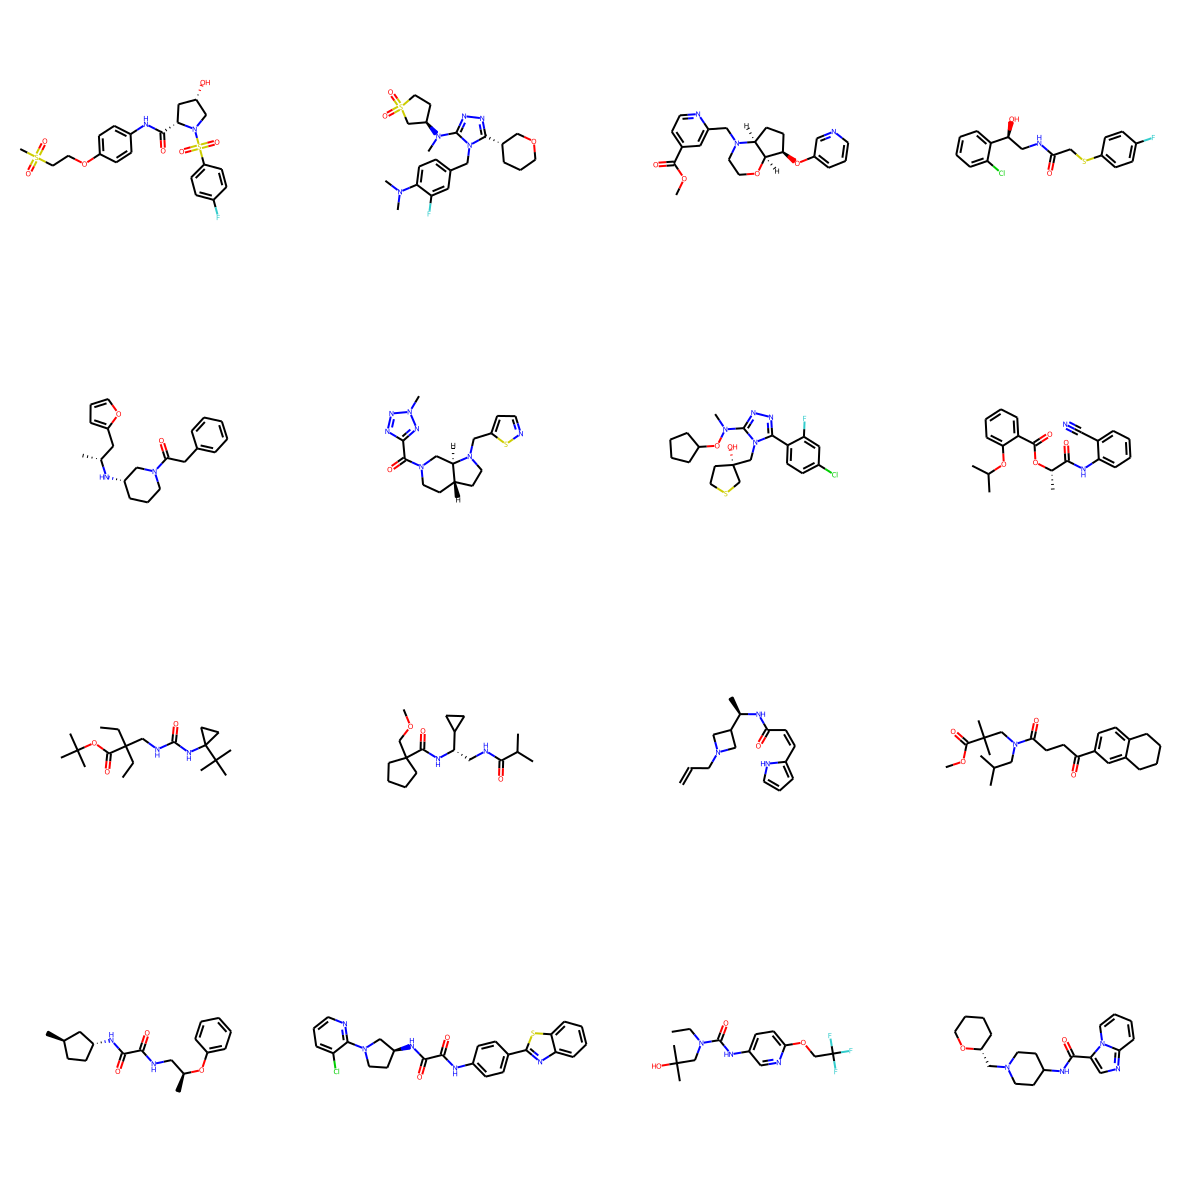

In [ ]:
draw_mols(valid_mols[:16], mols_per_row=4)

## Sampling Latent Space

We can sample from the latent space by drawing samples from a unit Gaussian

In [ ]:
latents = to_device(torch.randn((64, agent.model.encoder.d_latent)))

In [ ]:
preds, lps = agent.model.sample_no_grad(latents.shape[0], 100, z=latents, temperature=1.)
smiles = agent.reconstruct(preds)
mols = to_mols(smiles)
mols = [i for i in mols if i is not None]

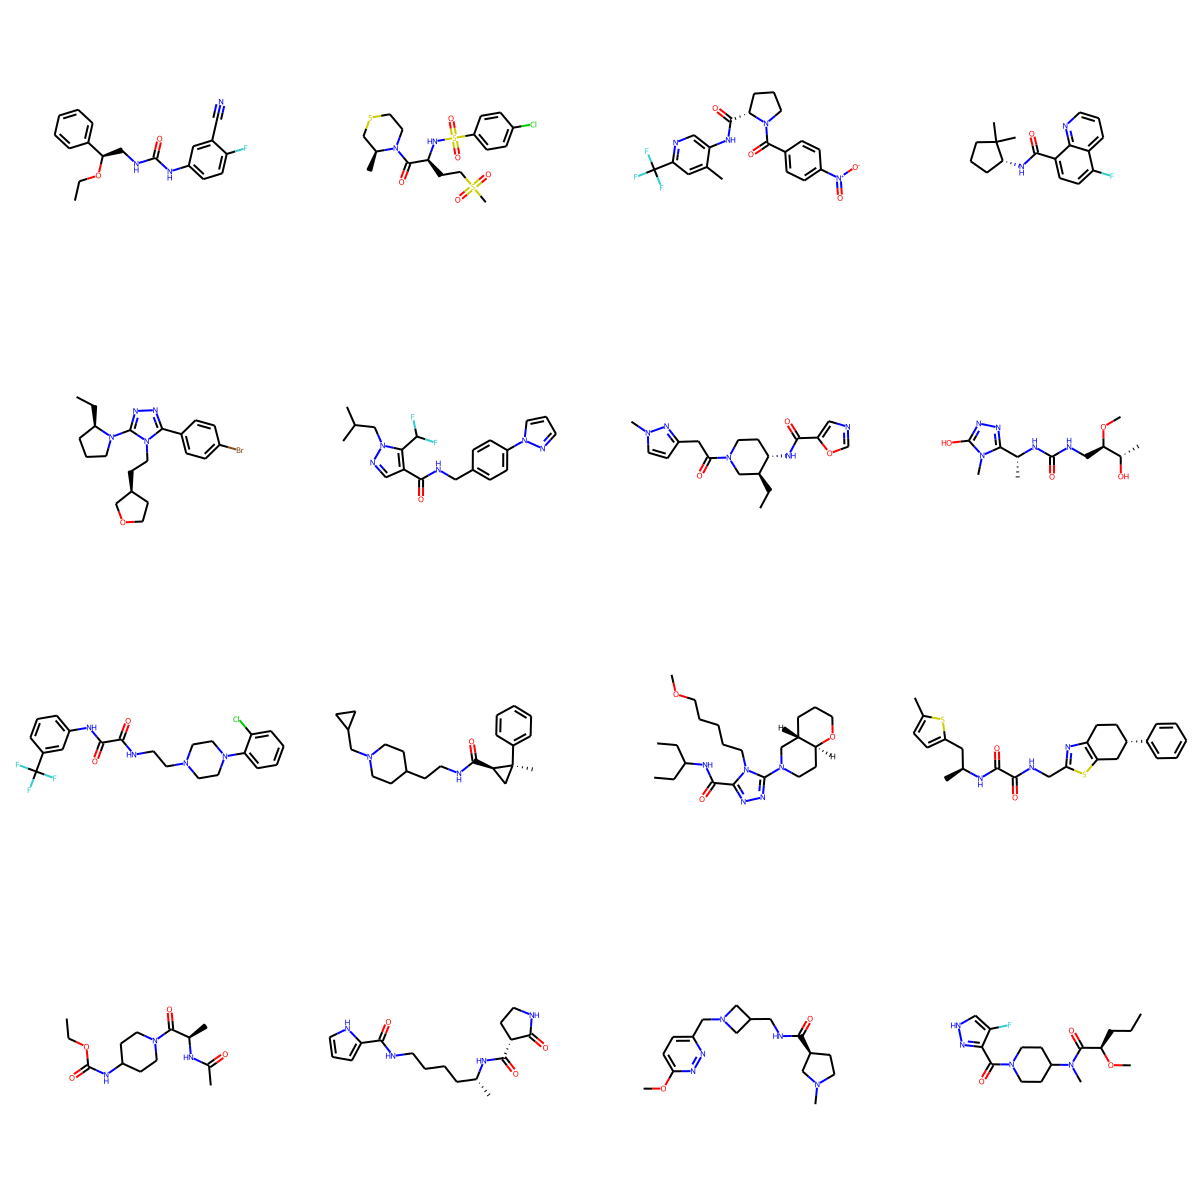

In [ ]:
draw_mols(mols[:16], mols_per_row=4)

## Conditional Samples on a Single Input

We can use the encoder to get a latent vector from aa given input. We can then use this vector to generate new samples

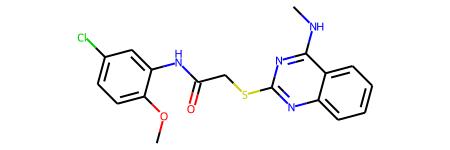

In [ ]:
smile = df.smiles.values[0]
to_mol(smile)

In [ ]:
smile_ds = dataset.new([smile])
batch = to_device(smile_ds.collate_function([smile_ds[0]]))
x,y = batch

In [ ]:
agent.model.eval();

In [ ]:
agent.model.z_scale = 1e-5

In [ ]:
latents = agent.model.x_to_latent(x)

In [ ]:
latents.shape

torch.Size([1, 512])

Now we sample 64 molecules from the same latent vector. The diversity of the outputs will depend on the sampling temperature used and the degree of dropout (if enabled)

In [ ]:
agent.model.train();

In [ ]:
preds, lps = agent.model.sample_no_grad(64, 100, z=latents.repeat(64,1), temperature=1.)
smiles = agent.reconstruct(preds)
print(len(set(smiles)), len(set(smiles))/len(smiles))
smiles = list(set(smiles))

64 1.0


In [ ]:
mols = to_mols(smiles)
mols = [i for i in mols if i is not None]

In [ ]:
len(mols)

64

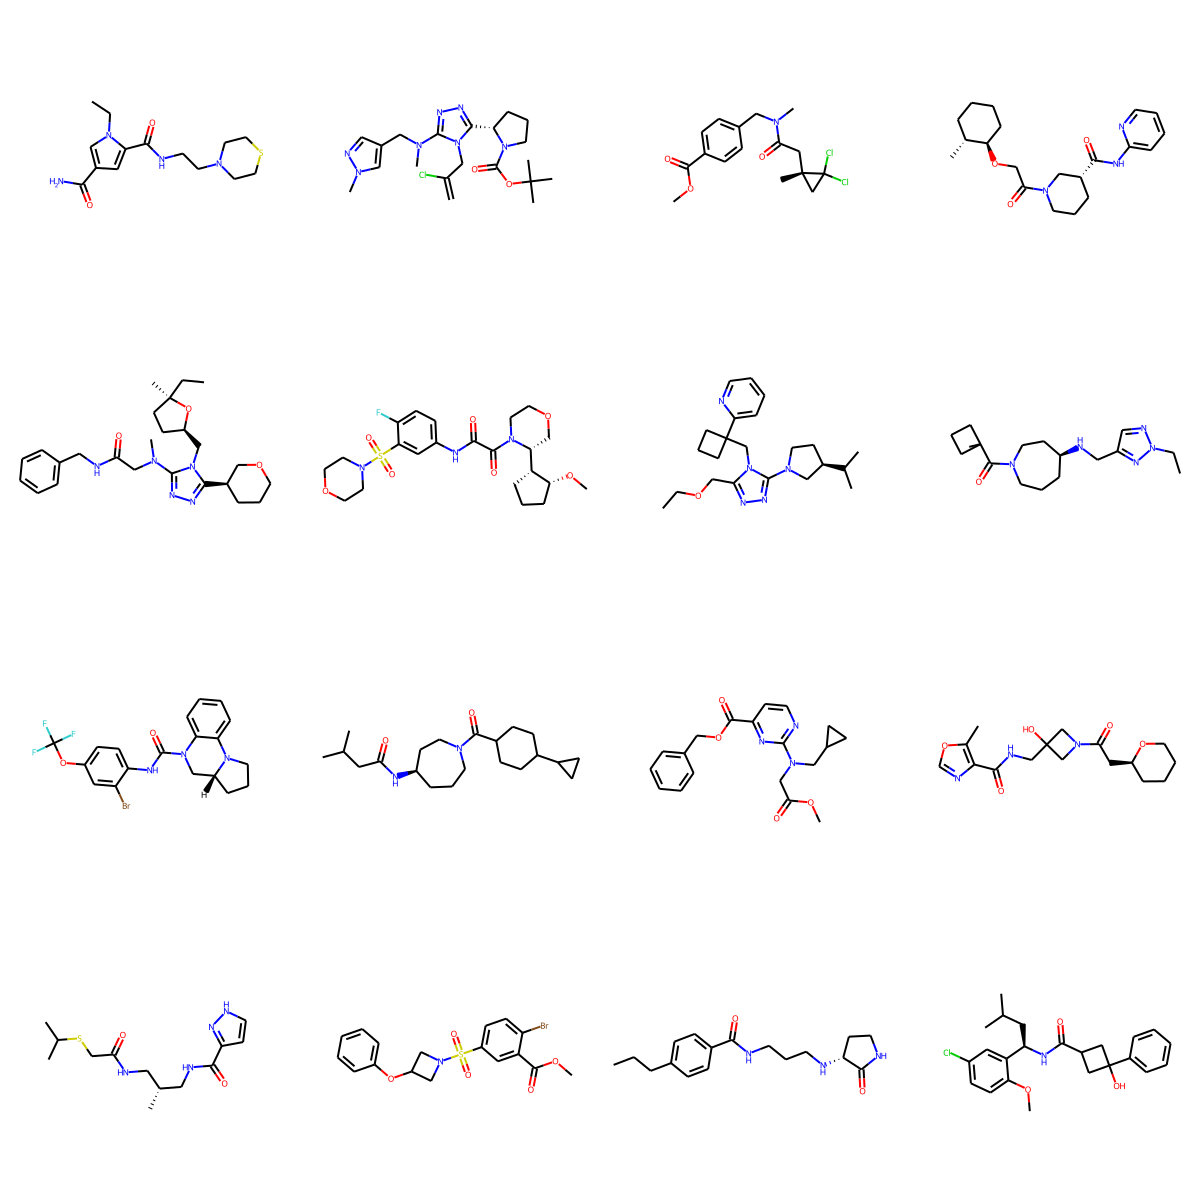

In [ ]:
draw_mols(mols[:16], mols_per_row=4)

Notice how the above compounds do not appear to be very similar to the input molecule, even though we sampled all output compounds from the same latent vector.

This is a feature of VAE-type models that are trained with a KL constraint. If robust reconstruction is needed, consider a model like `Conditional_LSTM_LM` which does not have the KL constraint